In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN
import talib
import multiprocessing
from deap import base, creator, tools, algorithms
import warnings

# DEAP creator 객체는 한 번만 생성되어야 합니다.
try:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
except RuntimeError:
    pass
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
except RuntimeError:
    pass

warnings.filterwarnings('ignore')

# 사용자가 제공한 모든 커스텀 모듈들을 가정하고 임포트합니다.
import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
import CandleChart as cc
import ROC as roc
import CV_ESN as cv_esn
import ESN_GA as esn_ga

# 모든 모듈을 다시 로드하여 최신 상태를 반영
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)
importlib.reload(cc)
importlib.reload(roc)
importlib.reload(cv_esn)

<module 'CV_ESN' from '/Users/munminjung/Capstone/CV_ESN.py'>

JNJ 데이터 로드 완료. 결측치 수:
 Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


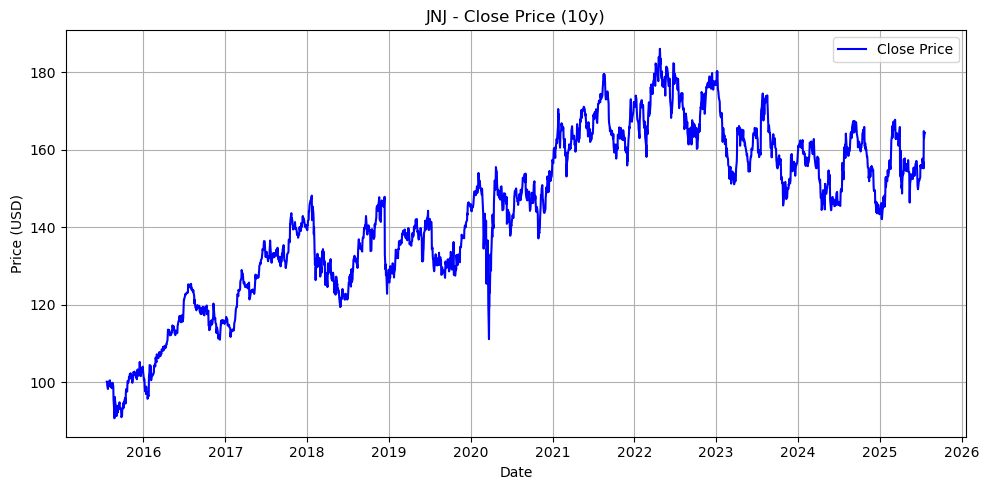

In [11]:
# --- 1. 데이터 수집 및 전처리 ---
name = 'JNJ'
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

print(f"{name} 데이터 로드 완료. 결측치 수:\n", ori_df.isnull().sum())

plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df = ori_df.copy()


CPM 모델 적용 중...


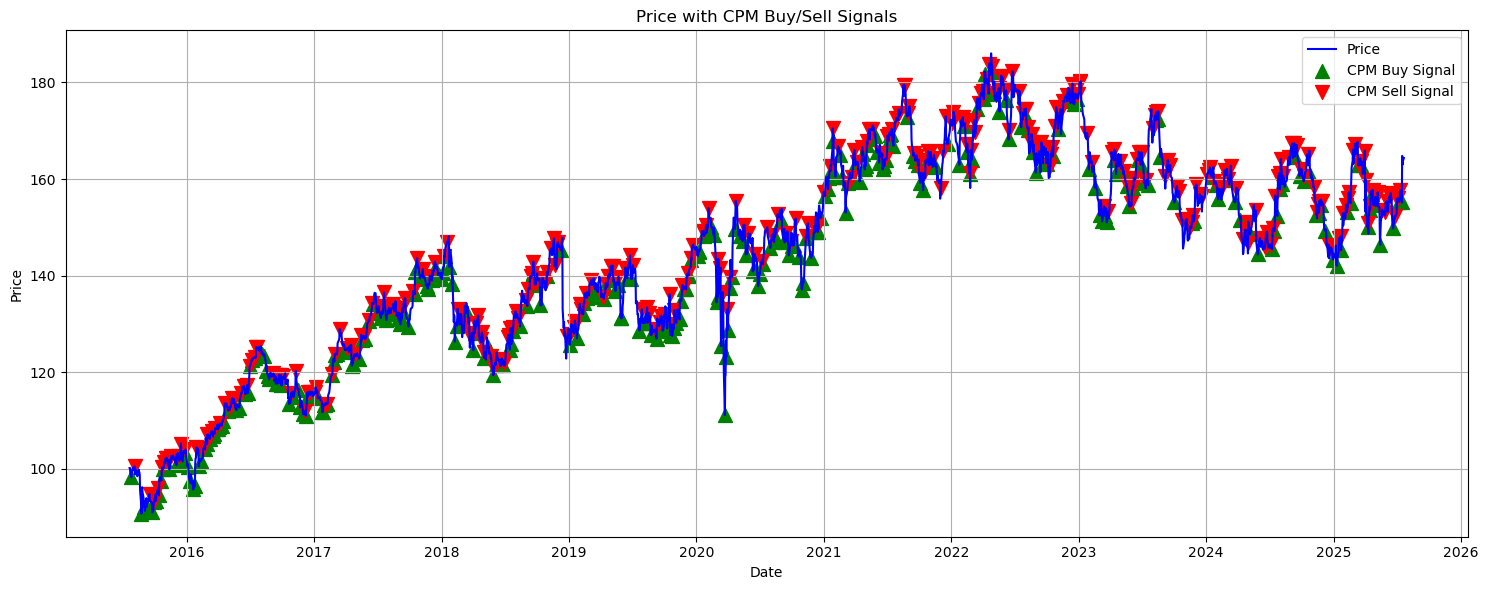

In [12]:
# --- 2. CPM 모델 적용 ---
print("\nCPM 모델 적용 중...")
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close', P=0.09, T=5)

cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index

plt.figure(figsize=(15, 6))
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')
plt.scatter(buy_indices, df_with_cpm.loc[buy_indices, 'Close'], label='CPM Buy Signal', marker='^', color='green', s=100)
plt.scatter(sell_indices, df_with_cpm.loc[sell_indices, 'Close'], label='CPM Sell Signal', marker='v', color='red', s=100)
plt.title("Price with CPM Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 데이터프레임 인덱스 정제
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()


# --- 3. 데이터 분할 ---
total_len = len(df)
train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end].copy()
test_df = df_with_cpm.iloc[train_end:].copy()

In [ ]:
# --- 4. 기술적 지표(TA) 유전 알고리즘(GA) 최적화 (훈련 데이터에서) ---
# 4.1. 이동평균 (MA)
print("\n이동평균(MA) 전략 최적화 시작...")
while True:
    try:
        ma_best_params, ma_best_fitness, _ = ma.run_MA_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in MA optimization: {e}. Retrying...")
        continue
print("\n--- MA 최적화 결과 ---")
print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

# 4.2. RSI (상대강도지수)
print("\nRSI 전략 최적화 시작...")
while True:
    try:
        rsi_best_params, rsi_best_fitness, _ = rsi.run_RSI_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in RSI optimization: {e}. Retrying...")
        continue
print("\n--- RSI 최적화 결과 ---")
print("Best Parameters:", rsi_best_params)
print("Best Fitness:", rsi_best_fitness)

# 4.3. CandleChart (캔들스틱 시너지)
print("\n캔들스틱 시너지 전략 최적화 시작...")
while True:
    try:
        cc_best_params, cc_best_fitness, _ = cc.run_candlestick_synergy_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in CC optimization: {e}. Retrying...")
        continue
print("\n--- 캔들스틱 시너지 최적화 결과 ---")
print("Best Parameters:", cc_best_params)
print("Best Fitness:", cc_best_fitness)

# 4.4. ROC (Rate of Change)
print("\nROC 전략 최적화 시작...")
while True:
    try:
        roc_best_params, roc_best_fitness, _ = roc.run_roc_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in ROC optimization: {e}. Retrying...")
        continue
print("\n--- ROC 최적화 결과 ---")
print("Best Parameters:", roc_best_params)
print("Best Fitness:", roc_best_fitness)

# 4.5. Stochastic
print("\nStochastic 전략 최적화 시작...")
while True:
    try:
        st_best_params, st_best_fitness, _ = st.run_stochastic_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in Stochastic optimization: {e}. Retrying...")
        continue
print("\n--- Stochastic 최적화 결과 ---")
print("Best Parameters:", st_best_params)
print("Best Fitness:", st_best_fitness)


이동평균(MA) 전략 최적화 시작...
이동평균 유전 알고리즘 실행 중...


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

gen	nevals	avg    	min    	max    
0  	50    	993.496	964.527	1044.16


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

1  	39    	inf    	921.83 	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

2  	39    	inf    	872.699	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

3  	38    	inf    	957.261	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

4  	35    	inf    	968.749	inf    
5  	47    	inf    	987.024	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

6  	40    	inf    	982.022	inf    
7  	41    	inf    	987.891	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


8  	35    	inf    	1003.37	inf    
9  	40    	inf    	1009.49	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


10 	41    	inf    	987    	inf    
11 	36    	inf    	inf    	inf    
12 	40    	inf    	1008.03	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


13 	29    	inf    	1035.5 	inf    
14 	41    	inf    	inf    	inf    
15 	34    	inf    	1021.33	inf    
16 	42    	inf    	inf    	inf    
17 	29    	inf    	inf    	inf    
18 	40    	inf    	inf    	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


19 	39    	inf    	1047.63	inf    
20 	39    	inf    	inf    	inf    
21 	31    	inf    	inf    	inf    
22 	43    	inf    	inf    	inf    
23 	36    	inf    	inf    	inf    
24 	45    	inf    	inf    	inf    
25 	37    	inf    	999.888	inf    
26 	39    	inf    	inf    	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


27 	42    	inf    	1014.17	inf    
28 	38    	inf    	994.022	inf    
29 	39    	inf    	inf    	inf    


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


30 	33    	inf    	1035.65	inf    
31 	37    	inf    	inf    	inf    
32 	43    	inf    	inf    	inf    
33 	39    	inf    	inf    	inf    
34 	34    	inf    	inf    	inf    
35 	37    	inf    	inf    	inf    
36 	41    	inf    	inf    	inf    
37 	42    	inf    	inf    	inf    
38 	38    	inf    	inf    	inf    
39 	35    	inf    	inf    	inf    
40 	37    	inf    	inf    	inf    
41 	31    	inf    	inf    	inf    
42 	34    	inf    	inf    	inf    
43 	35    	inf    	inf    	inf    
44 	42    	inf    	inf    	inf    
45 	43    	inf    	inf    	inf    
46 	42    	inf    	970.962	inf    
47 	30    	inf    	inf    	inf    
48 	38    	inf    	inf    	inf    
49 	40    	inf    	inf    	inf    
50 	48    	inf    	inf    	inf    
빈 데이터프레임 반환

--- 이동평균 유전 알고리즘 결과 ---
최적의 파라미터 (N, n, a, b, c): [65.81162785204152, -9.756385045087871, 6.727079917511118, 0.21175773932553105, 3.0605717363978058]
최소 적합도: inf
Error in MA optimization: TA_SMA function failed with error code 2: Bad Parameter (TA_BAD_

/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)


이동평균 유전 알고리즘 실행 중...


/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['position'].replace(0, method='ffill').fillna(0)
/Users/munminjung/Capstone/eval_signal1.py:107: FutureWarning: The 'meth

In [ ]:
# ESN에 입력될 기술적 지표 목록
Technical_Signals = ['MA_Signals', 'RSI_Signals', 'CC_Signals', 'ROC_Signals', 'Stochastic_Signals']

# --- 5. ESN 롤링-포워드 교차 검증 및 최적화 ---
print("\nESN 모델 롤링-포워드 교차 검증 시작...")

# 롤링 포워드 검증 및 최종 백테스팅에 사용할 TA 신호들을
# CPM 모델이 적용된 데이터프레임(df_with_cpm)에 생성
print("최적화된 파라미터로 데이터프레임에 기술적 지표 신호 생성 중...")

N, n, a, b, c = ma_best_params
df_with_cpm['MA_Signals'] = ma.generate_MA_signals(df_with_cpm, N, n, a, b, c)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

x, overbought_level, oversold_level, p, q = rsi_best_params
df_with_cpm['RSI_Signals'] = rsi.generate_RSI_signals(df_with_cpm, x, overbought_level, oversold_level, p, q)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

cc_a, cc_d, cc_e, cc_f, cc_g, cc_window = cc_best_params
df_with_cpm['CC_Signals'] = cc.generate_synergy_signals(df_with_cpm, cc_a, cc_d, cc_e, cc_f, cc_g, int(cc_window))['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

roc_period, roc_threshold = roc_best_params
df_with_cpm['ROC_Signals'] = roc.generate_roc_signals(df_with_cpm, int(roc_period), roc_threshold)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

st_a, st_b, st_c, st_d = st_best_params
df_with_cpm['Stochastic_Signals'] = st.generate_stochastic_signals(df_with_cpm, st_a, st_b, st_c, st_d)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

# 모든 신호가 추가된 데이터프레임(df_with_cpm)을 다시 훈련/테스트 데이터로 분할
train_df = df_with_cpm.iloc[:train_end].copy()
test_df = df_with_cpm.iloc[train_end:].copy()


# 롤링-포워드 교차 검증 실행
best_params_cv, cv_returns = cv_esn.esn_rolling_forward(
    df=train_df, # 훈련 데이터프레임을 전달
    technical_signals_list=Technical_Signals,
    n_splits=5,  # 5개 폴드로 분할
    pop_size=30,
    num_generations=15
)


# --- 6. 최종 백테스팅 및 시각화 ---
print("\n최종 ESN 모델 백테스팅 시작...")

# 롤링-포워드 최적화로 찾은 최적의 파라미터를 사용하여 테스트 데이터에 대한 백테스팅 수행
final_backtest_stats, final_signals = cv_esn.perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_cv,
    technical_signals_list=Technical_Signals,
    random_state=42
)

if final_backtest_stats is not None:
    print("\n--- 최종 백테스팅 결과 ---")
    print(final_backtest_stats)

    # 신호 시각화 함수 정의
    def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
        plt.figure(figsize=(16, 8))
        plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

        buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
        plt.scatter(buy_signals.index, buy_signals['Close'],
                    marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

        sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
        plt.scatter(sell_signals.index, sell_signals['Close'],
                    marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

        if 'cpm_point_type' in original_df.columns:
            cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
            cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

            plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                        marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

            plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                        marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
        else:
            print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

        plt.title(title, fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Close Price', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if final_signals is not None:
        plot_signals(test_df, final_signals, title="ESN Signals (Rolling-Forward Optimized) on Test Data")